# **💁🏻🗨️💁🏻‍♂️대화 요약 SOLAR API code**
> **Dialogue Summarization** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 자료에서는 Solar Chat API를 이용하여 대화 요약 대회를 풀어봅니다.     

## ⚙️ 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

In [ ]:
!pip install openai

In [4]:
import pandas as pd
import os
import time
from tqdm import tqdm
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.
from openai import OpenAI # openai==1.2.0

In [5]:
from dotenv import load_dotenv
from hydra import initialize, compose
import wandb

load_dotenv()
UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
# Jupyter 환경에서 실행
initialize(version_base="1.3", config_path="../config", job_name="test_app")  # config_path 지정
cfg = compose(config_name="config")  # config 파일 이름 지정
print(cfg)
os.chdir("../")
runtime_cwd = os.getcwd()  # 현재 작업 디렉터리 가져오기
print(f"runtime_cwd: {runtime_cwd}")
cfg.general.data_path = runtime_cwd + "/data"
cfg.general.model_cache_dir = runtime_cwd + "/models"
cfg.general.output_path = runtime_cwd + "/outputs"

{'prompt_templates': {'1': {'system': 'You are a Korean dialogue summarizer. Follow these rules:\n1. Summarize the dialogue in Korean only\n2. Keep the summary concise and simple\n3. Do not include any English text\n4. Focus on the key points only\n', 'few_shot': '다음 지시사항에 따라 대화를 요약하세요:\n1. 한국어로만 요약하세요\n2. 간단명료하게 작성하세요\n3. 핵심 내용만 포함하세요\n\nSample Dialogue:\n{sample_dialogue}\n\nSample Summary:\n{sample_summary}\n\nDialogue:\n{dialogue}\n\nSummary:\n', 'zero_shot': 'Summarize the following dialogue:\nDialogue: {dialogue}\nSummary:\n'}, '2': {'system': 'You are a Korean dialogue summarizer. Provide a concise summary in Korean only.\nRules:\n1. Only output the summary, nothing else\n2. Do not include any instructions or markers\n3. Keep it simple and focused\n', 'instruction': 'Please summarize the following dialogue in Korean.\nBe concise and focus on the key points.\n', 'few_shot': {'user': 'Dialogue:\n{sample_dialogue}\nSummary:\n', 'assistant': '{sample_summary}', 'final_user': 'Dialog

In [6]:

print(f"cfg.keys(): {cfg.keys()}")

# wandb.init(project=cfg.general.wandb.project, entity=cfg.general.wandb.entity, name=cfg.general.timestamp)

# wandb.log({"notebook test": 1})

# wandb.finish()


cfg.keys(): dict_keys(['prompt_templates', 'general', 'prompt', 'inference', 'url', 'metrics', 'huggingface', 'lora', 'custom_config', 'model', 'train'])


### 2) Solar Chat API Client 생성하기
- 앞으로 Solar Chat API를 사용하기 위해 Client를 생성합니다.

In [7]:
#UPSTAGE_API_KEY = "up_*****************************" # upstage.ai에서 발급받은 API KEY를 입력해주세요.

client = OpenAI(
    api_key=UPSTAGE_API_KEY,
    base_url="https://api.upstage.ai/v1/solar"
)

### 4) 데이터 불러오기
- 실험에서 쓰일 데이터를 load합니다.

In [60]:


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.font_manager as fm
from konlpy.tag import Okt
# !sudo apt update
# !sudo apt install -y fonts-nanum


# 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Gothic" in font or "Nanum" in font:  # 원하는 키워드 필터링
        print(font)

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

def data_load(cfg):
# 데이터 경로를 지정해줍니다.
    DATA_PATH = cfg.general.data_path
    RESULT_PATH = cfg.general.output_path

    # train data의 구조와 내용을 확인합니다.
    df = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
    print(df.tail())
    # dialog 와 summary 각각의 모델 max_length 설정을 위한 길이 확인

    dialog_length = df['dialogue'].apply(lambda x:len(x))
    summary_length = df['summary'].apply(lambda x:len(x))

    print("대화 길이에 대한 정보")
    print(dialog_length.describe())
    print("=================")
    print("요약문 길이에 대한 정보")
    print(summary_length.describe())
    return df


def text_replace(df, dict_replace):  
    # 데이터에서 특정 텍스트로 되어있는 부분이 있는지 확인하는 방법 : find 함수 사용
    print(f"========== {dict_replace.keys()} 포함된 데이터 확인 ==========")
    for key, value in dict_replace.items():
        
        val = df[df['dialogue'].apply(lambda x:x.find(key)!= -1)].values
        print(f"{key} 가 포함되어있는 데이터 확인 - 총 {len(val)} 개")
        print(val)
        if len(val) > 0:
            print(f"========== {key} 가 포함된 데이터 대체 시작 ==========")
            df['dialogue'] = df['dialogue'].apply(lambda x:x.replace(key, value))
            print(f"========== {key} 가 포함된 데이터 대체 완료 ==========")
            val = df[df['dialogue'].apply(lambda x:x.find(key)!= -1)].values
            print(f"{key} 가 포함되어있는 데이터 확인 - 총 {len(val)} 개")
            print(val)
    return df

def get_word_target(text, target, top_n=100):
    okt = Okt()
    print(f"========== {target} 타켓 추출 시작 ==========")
    if target == 'noun':
        target = okt.nouns(text)
    elif target == 'word':
        target = okt.morphs(text)
    for i,v in enumerate(target):
        if len(v)<2:
            target.pop(i)
    count = Counter(target)
    target_list = count.most_common(top_n)
    print(f"\n========== Target list:\n{target_list} \n==========")
    print(f"========== Count:\n{count} \n==========")
    return target_list

def visualize(target_list, title, font_path):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = font_path,    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(target_list))
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    return wc

import re
def reg_masking(text,):
  pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
  masked = re.findall(pattern, text)
  return masked

def reg_person(text):
  pattern = r"#\w+\d#"  # ## 사이의 값을 추출하는 정규식 패턴 > special token 으로 tokenizer에 추가
  masked = re.findall(pattern, text)
  return masked

# 우리, 정말과 같은 대화 주제별로 다른 단어가 아니라 일반적으로 대화에 많이 쓰는 단어들이 많이 등장하여 인사이트를 얻기가 조금 힘듭니다. 이런 경우를 방지하려고 TF-IDF(Term Frequency - Inverse Document Frequency) 라는 방법을 씁니다. 이는 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 수치인데, 이 방법을 사용하게 되면 여러 문서에서 공통적으로 자주 등장하는 단어보다는 특정 문서 내에서 더 중요하게 판단되는 단어를 추

/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothic.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf


             fname                                           dialogue  \
12452  train_12455  #Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...   
12453  train_12456  #Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...   
12454  train_12457  #Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...   
12455  train_12458  #Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...   
12456  train_12459  #Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...   

                                                 summary     topic  
12452  탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....  누군가를 태우다  
12453  #Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...   컨퍼런스 센터  
12454       #Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.      차 렌트  
12455  #Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...        실직  
12456  #Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...      짐 싸기  
대화 길이에 대한 정보
count    12457.000000
mean       438.765112
std        220.134710
min         99.000000
25%        299.000000
50%        396.000000
75

/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44208 (\N{HA

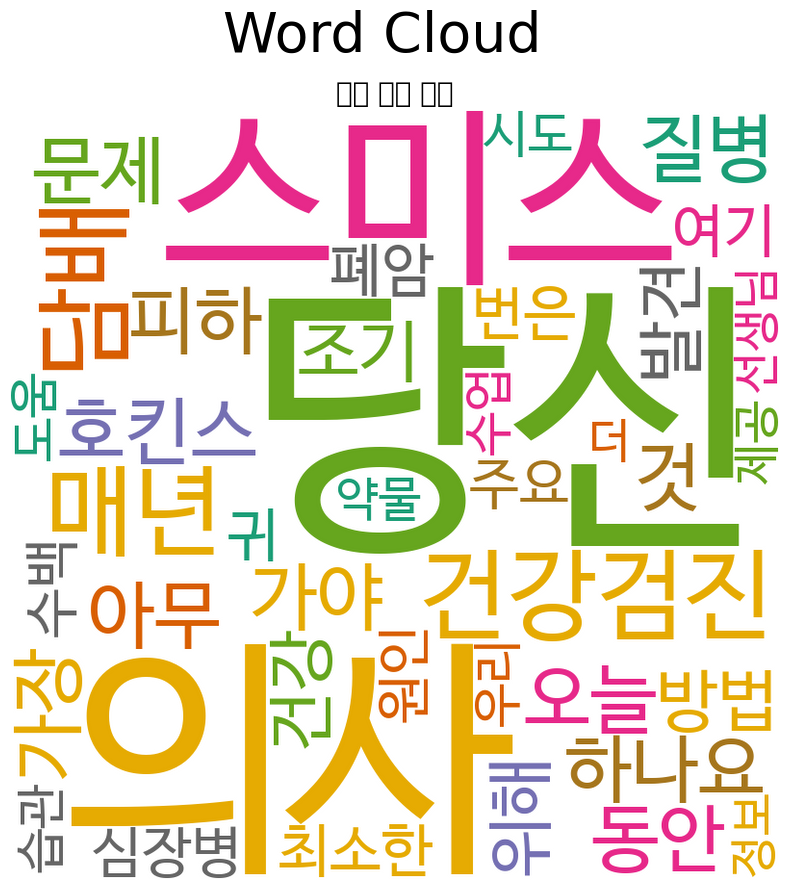

중복 제거된 해시태그 목록: {'#CarNumber#', '#PhoneNumber#', '#Person4#', '#Person6#', '#Person7#', '#Email#', '#Address#', '#CardNumber#', '#SSN#', '#DateOfBirth#', '#Person2#', '#PassportNumber#', '#Person5#', '#Person3#', '#Person1#', '#Person#'}
각 해시태그의 빈도수: {'#Person1#': 61318, '#Person2#': 56446, '#Person3#': 384, '#PhoneNumber#': 203, '#Address#': 45, '#PassportNumber#': 7, '#CardNumber#': 10, '#Person4#': 34, '#Person5#': 5, '#Person#': 1, '#CarNumber#': 6, '#Email#': 17, '#SSN#': 3, '#DateOfBirth#': 8, '#Person6#': 6, '#Person7#': 2}


,person_count
count,12457.000000
mean,2.011801
std,0.130849
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,7.000000


In [61]:

df =data_load(cfg)
dict_replace = {'ㅇㅇ':'','ㅋㅋ':'웃기다'}
df = text_replace(df, dict_replace)
# 단어 토큰화, 명사 추출 

idx = 0
okt=Okt()
words = okt.morphs(df['dialogue'].iloc[idx])
nouns = okt.nouns(df['dialogue'].iloc[idx])

print('단어 토큰화 결과 ==>', words)
print('명사 추출 결과 ==>', nouns)

get_word_target(df['dialogue'].iloc[idx], 'noun')
visualize(get_word_target(df['dialogue'].iloc[idx], 'noun'), '명사 추출 결과', font_path)

# 해당 데이터셋에는 개인정보가 포함되어 있었어서, 이 개인정보들을 마스킹 하여 제공합니다. 

# ###
# 전화번호 → #PhoneNumber#
# 주소 → #Address#
# 생년월일 → #DateOfBirth#
# 여권번호 → #PassportNumber#
# 사회보장번호 → #SSN#
# 신용카드 번호 → #CardNumber#
# 차량 번호 → #CarNumber#
# 이메일 주소 → #Email
# #### 
# 두 개의 # 사이에 어떤 정보가 마스킹 되어있는지를 표시합니다. 

# 이런 패턴을 가지고 있는 값들을 추출하기 위해서는 정규표현식을 사용할 수 있습니다. 

# 정규표현식 사용하기 

train_set = df['dialogue'].apply(lambda x:str(set(reg_masking(x))))

all_tags = df['dialogue'].apply(reg_masking).explode()  # 각 문장에서 추출된 태그를 펼침
tag_counts = Counter(all_tags)
unique_token =set(all_tags)

# 결과 출력
print("중복 제거된 해시태그 목록:", unique_token )
print("각 해시태그의 빈도수:", dict(tag_counts))

# 각 행 별 eg_person 수 추가
df['person_count'] = df['dialogue'].apply(lambda x: len(set(reg_person(x))))
# 결과 출력
df.describe()


In [59]:
# special token 추가
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v2")
special_tokens_dict = {'additional_special_tokens': list(unique_token)}
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


(['#CarNumber#',
  '#PhoneNumber#',
  '#Person4#',
  '#Person6#',
  '#Person7#',
  '#Email#',
  '#Address#',
  '#CardNumber#',
  '#SSN#',
  '#DateOfBirth#',
  '#Person2#',
  '#PassportNumber#',
  '#Person5#',
  '#Person3#',
  '#Person1#',
  '#Person#'],
 [30000,
  30001,
  30002,
  30003,
  30004,
  30005,
  30006,
  30007,
  30008,
  30009,
  30010,
  30011,
  30012,
  30013,
  30014,
  30015])

In [26]:
nouns = get_noun(train_df['dialogue'].iloc[0])


[('당신', 4),
 ('의사', 3),
 ('스미스', 2),
 ('건강검진', 2),
 ('매년', 2),
 ('담배', 2),
 ('호킨스', 1),
 ('오늘', 1),
 ('것', 1),
 ('동안', 1),
 ('아무', 1),
 ('문제', 1),
 ('가야', 1),
 ('하나요', 1),
 ('질병', 1),
 ('피하', 1),
 ('가장', 1),
 ('방법', 1),
 ('조기', 1),
 ('발견', 1),
 ('건강', 1),
 ('위해', 1),
 ('최소한', 1),
 ('번은', 1),
 ('여기', 1),
 ('귀', 1),
 ('폐암', 1),
 ('심장병', 1),
 ('주요', 1),
 ('원인', 1),
 ('수백', 1),
 ('시도', 1),
 ('습관', 1),
 ('우리', 1),
 ('도움', 1),
 ('수업', 1),
 ('약물', 1),
 ('제공', 1),
 ('더', 1),
 ('정보', 1),
 ('선생님', 1)]

In [ ]:
total_reviews = visualize(nouns,'total') # 워드클라우드 시각화

In [ ]:
# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(DATA_PATH,'dev.csv'))
val_df.tail()

## 1. Solar Chat API 요약 성능 확인하기
- Solar Chat API을 이용하여 train 및 validation dataset에 포함된 dialogue 샘플을 요약해 봅니다.

In [ ]:
# 모델 성능에 대한 평가 지표를 정의합니다. 본 대회에서는 ROUGE 점수를 통해 모델의 성능을 평가합니다.
rouge = Rouge()
def compute_metrics(pred, gold):
    results = rouge.get_scores(pred, gold, avg=True)
    result = {key: value["f"] for key, value in results.items()}
    return result

In [ ]:
# Dialogue를 입력으로 받아, Solar Chat API에 보낼 Prompt를 생성하는 함수를 정의합니다.
def build_prompt(dialogue):
    system_prompt = "You are an expert in the field of dialogue summarization. Please summarize the following dialogue."

    user_prompt = f"Dialogue:\n{dialogue}\n\nSummary:\n"
    
    return [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

In [ ]:
# Solar Chat API를 활용해 Summarization을 수행하는 함수를 정의합니다.
def summarization(dialogue):
    summary = client.chat.completions.create(
        model="solar-1-mini-chat",
        messages=build_prompt(dialogue),
    )

    return summary.choices[0].message.content

### (선택) parameter 변경하기
- Solar Chat API를 사용할 때, parameter를 변경하여, 다양한 결과를 얻을 수 있습니다.
- Parameter에 대한 자세한 설명은 [여기](https://developers.upstage.ai/docs/apis/chat#request-body)를 참고해주세요.

In [ ]:
def summarization(dialogue):
    summary = client.chat.completions.create(
        model="solar-1-mini-chat",
        messages=build_prompt(dialogue),
        temperature=0.2,
        top_p=0.3,
    )

    return summary.choices[0].message.content

Train Dataset을 이용하여 요약이 잘 되는지 확인해 봅니다.

In [ ]:
# Train data 중 처음 3개의 대화를 요약합니다.
def test_on_train_data(num_samples=3):
    for idx, row in train_df[:num_samples].iterrows():
        dialogue = row['dialogue']
        summary = summarization(dialogue)
        print(f"Dialogue:\n{dialogue}\n")
        print(f"Pred Summary: {summary}\n")
        print(f"Gold Summary: {row['summary']}\n")
        print("=="*50)

In [ ]:
if __name__ == "__main__":
    test_on_train_data()

Validation Dataset을 이용하여 요약을 진행하고, 성능을 평가해 봅니다.

In [ ]:
# Validation data의 대화를 요약하고, 점수를 측정합니다.
def validate(num_samples=-1):
    val_samples = val_df[:num_samples] if num_samples > 0 else val_df
    
    scores = []
    for idx, row in tqdm(val_samples.iterrows(), total=len(val_samples)):
        dialogue = row['dialogue']
        summary = summarization(dialogue)
        results = compute_metrics(summary, row['summary'])
        avg_score = sum(results.values()) / len(results)
        
        scores.append(avg_score)
        
    val_avg_score = sum(scores) / len(scores)

    print(f"Validation Average Score: {val_avg_score}")

In [ ]:
if __name__ == "__main__":
    validate(100) # 100개의 validation sample에 대한 요약을 수행합니다.
    
    # 전체 validation data에 대한 요약을 수행하고 싶은 경우 아래와 같이 실행합니다.
    # validate() 

## 2. Solar Chat API로 요약하기
- Solar Chat API을 이용하여 test dataset에 포함된 dialogue를 요약하고 제출용 파일을 생성합니다.

In [ ]:
def inference():
    test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

    summary = []
    start_time = time.time()
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        dialogue = row['dialogue']
        summary.append(summarization(dialogue))
        
        # Rate limit 방지를 위해 1분 동안 최대 100개의 요청을 보내도록 합니다.
        if (idx + 1) % 100 == 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            if elapsed_time < 60:
                wait_time = 60 - elapsed_time + 5
                print(f"Elapsed time: {elapsed_time:.2f} sec")
                print(f"Waiting for {wait_time} sec")
                time.sleep(wait_time)
            
            start_time = time.time()
    
    output = pd.DataFrame(
        {
            "fname": test_df['fname'],
            "summary" : summary,
        }
    )
    
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
    output.to_csv(os.path.join(RESULT_PATH, "output_solar.csv"), index=False)

    return output

In [ ]:
if __name__ == "__main__":
    output = inference()

In [ ]:
output  # 각 대화문에 대한 요약문이 출력됨을 확인할 수 있습니다.

## 3. Prompt Engineering
- Prompt engineering을 통해 요약 성능 향상을 시도합니다.

In [ ]:
# Few-shot prompt를 생성하기 위해, train data의 일부를 사용합니다.
few_shot_samples = train_df.sample(1)

sample_dialogue1 = few_shot_samples.iloc[0]['dialogue']
sample_summary1 = few_shot_samples.iloc[0]['summary']

print(f"Sample Dialogue1:\n{sample_dialogue1}\n")
print(f"Sample Summary1: {sample_summary1}\n")

In [ ]:
# Prompt를 생성하는 함수를 수정합니다.
def build_prompt(dialogue):
    system_prompt = "You are a expert in the field of dialogue summarization, summarize the given dialogue in a concise manner. Follow the user's instruction carefully and provide a summary that is relevant to the dialogue."

    user_prompt = (
        "Following the instructions below, summarize the given document.\n"
        "Instructions:\n"
        "1. Read the provided sample dialogue and corresponding summary.\n"
        "2. Read the dialogue carefully.\n"
        "3. Following the sample's style of summary, provide a concise summary of the given dialogue.\n\n"
        "Sample Dialogue:\n"
        f"{sample_dialogue1}\n\n"
        "Sample Summary:\n"
        f"{sample_summary1}\n\n"
        "Dialogue:\n"
        f"{dialogue}\n\n"
        "Summary:\n"
    )
    
    return [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

In [ ]:
# 변경된 prompt를 사용하여, train data 중 처음 3개의 대화를 요약하고, 결과를 확인합니다.
if __name__ == "__main__":
    test_on_train_data()

In [ ]:
# 변경된 prompt를 사용하여, validation data의 대화를 요약하고, 점수를 측정합니다.
if __name__ == "__main__":
    validate(100)

다른 방식으로 Few-shot sample을 제공하여 Prompt를 구성해 봅니다.

In [ ]:
# Few-shot sample을 다른 방식으로 사용하여 prompt를 생성합니다.
def build_prompt(dialogue):
    system_prompt = "You are a expert in the field of dialogue summarization, summarize the given dialogue in a concise manner. Follow the user's instruction carefully and provide a summary that is relevant to the dialogue."

    few_shot_user_prompt_1 = (
        "Following the instructions below, summarize the given document.\n"
        "Instructions:\n"
        "1. Read the provided sample dialogue and corresponding summary.\n"
        "2. Read the dialogue carefully.\n"
        "3. Following the sample's style of summary, provide a concise summary of the given dialogue. Be sure that the summary is simple but captures the essence of the dialogue.\n\n"
        "Dialogue:\n"
        f"{sample_dialogue1}\n\n"
        "Summary:\n"
    )
    few_shot_assistant_prompt_1 = sample_summary1
    
    user_prompt = (
        "Dialogue:\n"
        f"{dialogue}\n\n"
        "Summary:\n"
    )
    
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": few_shot_user_prompt_1},
        {"role": "assistant", "content": few_shot_assistant_prompt_1},
        {"role": "user", "content": user_prompt},
    ]

In [ ]:
# 변경된 prompt를 사용하여, train data 중 처음 3개의 대화를 요약하고, 결과를 확인합니다.
if __name__ == "__main__":
    test_on_train_data()

In [ ]:
# 변경된 prompt를 사용하여, validation data의 대화를 요약하고, 점수를 측정합니다.
if __name__ == "__main__":
    validate(100)

### (선택) 변경된 Prompt로 test dataset에 대한 요약을 진행합니다.
- 변경된 prompt를 통해 점수가 개선되었다면, test dataset에 대한 요약을 진행하고 제출합니다.

In [ ]:
# 변경된 prompt를 사용하여, test data의 대화를 요약하고, 결과를 확인합니다.
if __name__ == "__main__":
    output = inference()

In [ ]:
output